# <a id='toc1_'></a>[UCRB Streamflow Sandbox](#toc0_)
Author: Daniel Hogan

Creation Date: 2023-04-25

This notebook explores the general trends in streamflow, precipitation, and temperature across the UCRB.
Figure 1 from the publication is created within, along with figures in the SI Appendix. See table of contents to get main ideas.

**Note: Links in the TOC will not work in GitHub**

**Table of contents**<a id='toc0_'></a>    
- [UCRB Streamflow Sandbox](#toc1_)    
    - [Import Packages](#toc1_1_1_)    
- [Import UCRB PRISM temperature and precipitation data](#toc2_)    
    - [Temperature](#toc2_1_1_)    
    - [Precipitation](#toc2_1_2_)    
- [Import naturalized streamflow](#toc3_)    
- [Plot Precipitation, Streamflow and Temperature all together](#toc4_)    
    - [Plot streamflow and precipitation standardized anomalies](#toc4_1_1_)    
    - [Figure 1 A Plot within Manuscript](#toc4_1_2_)    
    - [Streamflow, Precipitation, Temperature Figure used in Supplemental Text](#toc4_1_3_)    
- [Let's change to focusing on our HCDN basins](#toc5_)    
- [Cumulative Streamflow Deficit Plots](#toc6_)    
    - [Quick Statistical test for a single site](#toc6_1_1_)    
    - [Double Mass Plots](#toc6_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Import Packages](#toc0_)

In [1]:
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
import scipy.stats as stats
import numpy as np
import datetime as dt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib as mpl
import os
from dataretrieval import nwis

# <a id='toc2_'></a>[Import UCRB PRISM temperature and precipitation data](#toc0_)

In [2]:
#EPSG code
co_epsg = 32613

# pull in UCRB basin 
ucrb_basin_boundary = gpd.read_file('../data/geodata/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(co_epsg)

Check if a specific directory (../data/etdata/prism_tmean_normals) exists. If the directory does not exist, it proceeds to retrieve PRISM temperature data, reprojects and clips it based on specified parameters, and saves the result to a NetCDF file (../data/etdata/prism_tmean_normals.nc). If the directory already exists, it loads the temperature data from the existing NetCDF file instead.

PRISM data was downloaded from https://prism.oregonstate.edu/historical/. Filtered and saved data are available at the zenodo site referenced in the repository README.

### <a id='toc2_1_1_'></a>[Temperature](#toc0_)

Save PRISM climatological normals between 1990-2020

In [3]:
if not os.path.exists('../data/etdata/prism_tmean_normals'):
    # pull in PRISM data
    outpath = '../data/etdata/PRISM_tmean_30yr_normal_800mM4_annual_bil/'
    prism_tmean_normal = rxr.open_rasterio(outpath + 'PRISM_tmean_30yr_normal_800mM4_annual_bil.bil', masked=True)
    ucrb_prism_tmean_normal = prism_tmean_normal.rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry).squeeze()
    # save to file
    ucrb_prism_tmean_normal.to_netcdf('../data/etdata/prism_tmean_normals.nc')
else:
    ucrb_prism_tmean_normal = xr.open_dataset('../data/etdata/prism_tmean_normals.nc')

Save PRISM temperature between 1895 and 2022 (whole time series)

In [4]:
if not os.path.exists('../data/etdata/prism_tmean_4km_ucrb.nc'):
       # Download PRISM precipitation from 4km product 
       outpath = '/storage/dlhogan/sos/data/PRISM/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 39)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_tmean_ds = xr.concat(prism_list, dim='band')
       prism_4km_tmean_ds = prism_4km_tmean_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_tmean_ds = prism_4km_tmean_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 

       # Filter to correct dates
       prism_4km_tmean_ds = prism_4km_tmean_ds.sortby('month')
       prism_4km_tmean_ds = prism_4km_tmean_ds.sel(month=slice('1895-01-01', '2022-09-01'))

       prism_4km_tmean_ds.to_netcdf('../data/etdata/prism_tmean_4km_ucrb.nc')
else:
       prism_4km_tmean_ds = xr.open_dataset('../data/etdata/prism_tmean_4km_ucrb.nc')

### <a id='toc2_1_2_'></a>[Precipitation](#toc0_)

First download 1981 to 2022 data and add it to a netcdf

In [5]:
if not os.path.exists('../data/precipdata/prism_4km_ucrb.nc'):
       # Download PRISM precipitation from 4km product 
       outpath = '../data/precipdata/PRISM/PRISM_ppt_stable_4km/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_ds = xr.concat(prism_list, dim='band', join='override')
       prism_4km_ds = prism_4km_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_ds = prism_4km_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 

       # Filter to correct dates between 1981 and 2022
       prism_4km_ds = prism_4km_ds.sortby('month')
       prism_4km_ds = prism_4km_ds.sel(month=slice('1981-01-01', '2022-09-01'))

Add historical data from 1964 to present

In [6]:
# Download historic PRISM precipitation from 4km product 
# this otupath should contain historical prism data 
outpath = '/storage/dlhogan/sos/data/PRISM_ppt/'
if not os.path.exists('../data/precipdata/prism_4km_ucrb.nc'):
       # get file name list
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
       prism_list = []
       dates = []
       # Open each file and append to a list
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       # concatentate each file to netcdf
       prism_4km_historic_ds = xr.concat(prism_list, dim='band')
       prism_4km_historic_ds = prism_4km_historic_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_historic_ds = prism_4km_historic_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 
       prism_4km_historic_ds = prism_4km_historic_ds.sortby('month')
       prism_4km_all_ds = xr.concat([prism_4km_historic_ds, prism_4km_ds], dim='month', join='override')
       prism_4km_all_ds.to_netcdf('../data/precipdata/prism_4km_ucrb.nc')
else:
       prism_4km_all_ds = xr.open_dataset('../data/precipdata/prism_4km_ucrb.nc')
       prism_4km_all_ds = prism_4km_all_ds.rename({'__xarray_dataarray_variable__':'ppt'})

# <a id='toc3_'></a>[Import naturalized streamflow](#toc0_)

Naturalized streamflow data downloaded from https://www.usbr.gov/lc/region/g4000/NaturalFlow/provisional.html

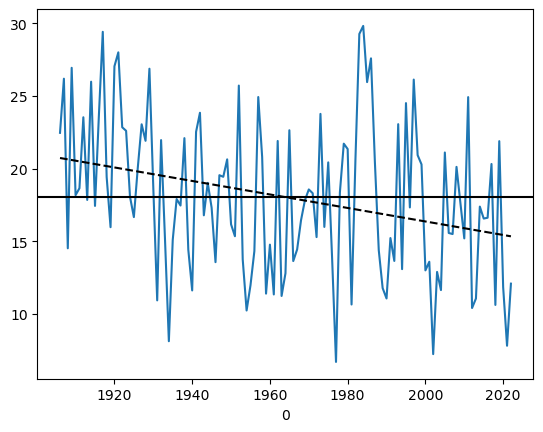

In [7]:
ucrb_naturalized_streamflow = pd.read_csv('../data/streamflowdata/LF_NATURALIZED_FLOW.csv', header=None, index_col=0)
ucrb_naturalized_streamflow = ucrb_naturalized_streamflow.rename(columns={1:'annual_flow_km3'}) * 1.23348e-6
ucrb_naturalized_streamflow['q_mm_day'] = ucrb_naturalized_streamflow['annual_flow_km3'] * 1e9 / 365 /ucrb_basin_boundary.area.values[0] * 1000
ucrb_naturalized_streamflow['annual_flow_anom'] = (ucrb_naturalized_streamflow['annual_flow_km3']-ucrb_naturalized_streamflow['annual_flow_km3'].mean())/ucrb_naturalized_streamflow['annual_flow_km3'].std()
slope1, intercept1, _,_,_ = stats.linregress(ucrb_naturalized_streamflow.index,ucrb_naturalized_streamflow['annual_flow_km3'].values)
ucrb_naturalized_streamflow['annual_flow_km3'].plot()
plt.plot(ucrb_naturalized_streamflow.index , slope1*ucrb_naturalized_streamflow.index + intercept1, ls='--',color='k')
plt.axhline(ucrb_naturalized_streamflow['annual_flow_km3'].mean(), color='k')

Calculate annual precipitation for each water year and convert to cubic kilometers

In [8]:
p_mean = prism_4km_all_ds.where(prism_4km_all_ds>0).mean(dim=['x','y'])
p_mean['WY'] = p_mean.month.dt.year.where(p_mean.month.dt.month<10, p_mean.month.dt.year+1)
annual_p_sum = p_mean.groupby('WY').sum()
annual_p_km3 = (annual_p_sum / 1000) * np.full(len(annual_p_sum.WY), ucrb_basin_boundary.area) / 1e9
annual_p_km3 = annual_p_km3.sel(WY=slice(1896,2022))
annual_p_km3 = annual_p_km3.rename({'ppt':'p_km3'})

Quick plot of precipitation trend over time. Note the limited trend

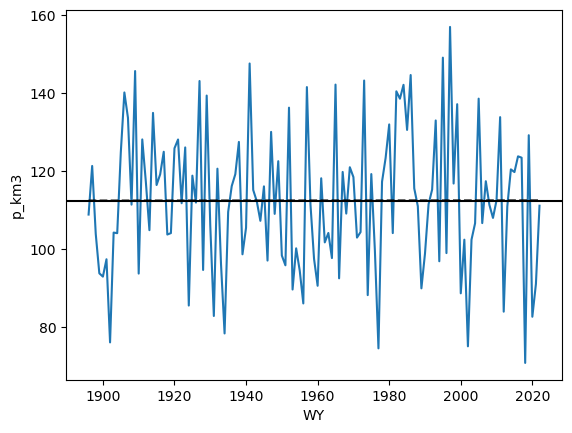

In [9]:
slope2, intercept2, _,_,_ = stats.linregress(annual_p_km3.WY,annual_p_km3['p_km3'].values)
annual_p_km3['p_km3'].plot()
plt.plot(annual_p_km3.WY , slope2*annual_p_km3.WY + intercept2, ls='--',color='k')
plt.axhline(annual_p_km3['p_km3'].mean(), color='k')

Calculate mean annual temperture for each water year

In [10]:
t_mean = prism_4km_tmean_ds.where(prism_4km_tmean_ds>-100).mean(dim=['x','y'])
t_mean['WY'] = t_mean.month.dt.year.where(t_mean.month.dt.month<10, t_mean.month.dt.year+1)
annual_t_mean = t_mean.groupby('WY').mean()
annual_t_mean = annual_t_mean.rename({'__xarray_dataarray_variable__':'t_mean'})
annual_t_mean = annual_t_mean.sel(WY=slice(1896,2022))


Quick plot of trend, note the increasing temperature with time

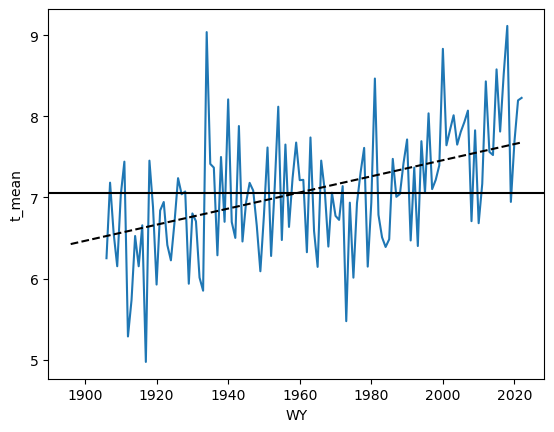

In [11]:
slope3, intercept3, _,_,_ = stats.linregress(annual_t_mean.WY,annual_t_mean['t_mean'].values)
annual_t_mean['t_mean'].sel(WY=slice(1906,2022)).plot()
plt.plot(annual_t_mean.WY , slope3*annual_t_mean.WY + intercept3, ls='--',color='k')
plt.axhline(annual_t_mean['t_mean'].mean(), color='k')

# <a id='toc4_'></a>[Plot Precipitation, Streamflow and Temperature all together](#toc0_)

In [12]:
# convert ucrb index to datetime and add month=1 and day=1
ucrb_naturalized_streamflow.index = pd.to_datetime([dt.datetime(x,1,1) for x in ucrb_naturalized_streamflow.index])

In [13]:
# Create a copy to be used in plotting the x-axis
ucrb_naturalized_streamflow_tmp = ucrb_naturalized_streamflow.copy()
ucrb_naturalized_streamflow_tmp.index = ucrb_naturalized_streamflow.index.year

Plot created for visualization of Millennium Drought and Baseline periods

(-23376.0, 18993.0)

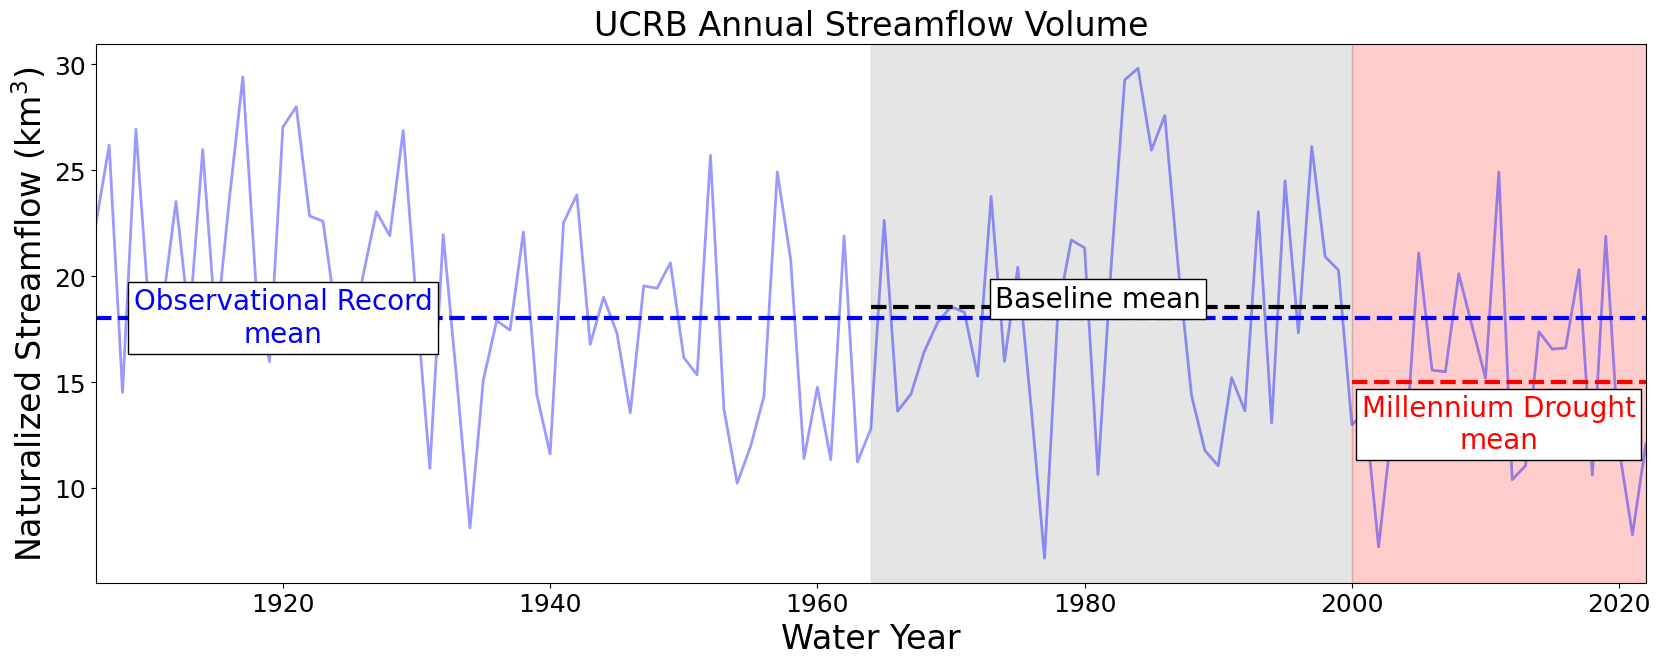

In [14]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(ucrb_naturalized_streamflow.index, 
        ucrb_naturalized_streamflow['annual_flow_km3'], 
        color='b', 
        alpha=0.4,
        lw=2)
####### RECORD #######
# plot the mean between 1906 and 2022
ax.axhline(ucrb_naturalized_streamflow['annual_flow_km3'].loc['1906':'2022'].mean(), color='b', lw=3,ls='--')
# add label above the line on the far left of the plot 1906-1999 mean
ax.text(dt.datetime(1920,1,1), 
        ucrb_naturalized_streamflow['annual_flow_km3'].loc['1906':'2022'].mean(), 
        'Observational Record\nmean', 
        # add white text box around the text
        bbox=dict(facecolor='white', alpha=1, edgecolor='k'),
        ha='center',
        va='center',
        color='b', 
        size=20)
######## MILLENNIUM DROUGHT ########
# plot the mean between 2000 and 2022 starting on jan 1 2000 
ax.plot([dt.datetime(2000,1,1), dt.datetime(2022,1,1)],
        [ucrb_naturalized_streamflow['annual_flow_km3'].loc['2000':'2022'].mean(), ucrb_naturalized_streamflow['annual_flow_km3'].loc['2000':'2022'].mean()],
        color='r', 
        ls='--',
        lw=3)
# add label above the line on the far left of the plot 2000-2022 mean
ax.text(dt.datetime(2011,1,1), 
        ucrb_naturalized_streamflow['annual_flow_km3'].loc['2000':'2022'].mean()-2, 
        'Millennium Drought\nmean', 
        # add white text box around the text
        bbox=dict(facecolor='white', alpha=1, edgecolor='k'),
        ha='center',
        va='center',
        color='r',
        size=20)

# add axvspan between 2000 and 2022
ax.axvspan(dt.datetime(1999,12,31), dt.datetime(2022,1,1), alpha=0.2, color='red')

######## BASELINE PERIOD ########
# plot the mean between 1964 and 1999 starting on jan 1 1964
ax.plot([dt.datetime(1964,1,1), dt.datetime(1999,12,31)],
        [ucrb_naturalized_streamflow['annual_flow_km3'].loc['1964':'1999'].mean(), ucrb_naturalized_streamflow['annual_flow_km3'].loc['1964':'1999'].mean()],
        color='k',
        ls='--',
        lw=3)
# add label below the line on the far left of the plot 1964-1999 mean
ax.text(dt.datetime(1981,1,1), 
        ucrb_naturalized_streamflow['annual_flow_km3'].loc['1964':'1999'].mean(), 
        'Baseline mean', 
        # add white text box around the text
        bbox=dict(facecolor='white', alpha=1, edgecolor='k'),
        ha='center',
        size=20)
# add axvspan between 1964 and 1999
ax.axvspan(dt.datetime(1964,1,1), dt.datetime(1999,12,31), alpha=0.2, color='gray')


# tick parameters
# increase tick size
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
# labels and titles
ax.set_ylabel('Naturalized Streamflow (km$^3$)', size=24)
ax.set_xlabel('Water Year', size=24)
# Add title 
ax.set_title('UCRB Annual Streamflow Volume', size=24)
# limits with datetime between 1910 and 2022
ax.set_xlim([dt.datetime(1906,1,1), dt.datetime(2022,1,1)])



### How much of the runoff deficit is explained by the precipitation deficit?

In [15]:
# how much of the runoff deficit is explained by the precipitation deficit
# create a dataframe with the data
df = pd.DataFrame({'p':annual_p_km3.sel(WY=slice(1964,2022))['p_km3'].values, 
                   't':annual_t_mean.sel(WY=slice(1964,2022))['t_mean'].values,
                   'q':ucrb_naturalized_streamflow.loc['1964-01-01':'2022-01-01']['annual_flow_km3'].values}, index = annual_p_km3.sel(WY=slice(1964,2022)).WY.values)

# convert each value to a deficit from the mean
df['p_anom'] = (df['p']-df['p'].loc[1964:1999].mean())
df['t_anom'] = (df['t']-df['t'].loc[1964:1999].mean())
df['q_anom'] = (df['q']-df['q'].loc[1964:1999].mean())
# run a model to see how much of the variance in q is explained by p
# create a training period from 1950 to 2022
train = df.loc[1964:1999]
# create a testing period from 2000 to 2022
test = df.loc[2000:2022]
model_train = ols('q_anom ~ p_anom + t_anom', data=train).fit()

# apply the trained model to the test period
model_test = model_train.predict(test)

# calculate the sum of the deficit over the 2000-2022 period
q_deficit = train['q_anom'].loc[1964:1999].sum()
q_deficit_test = test['q_anom'].sum()
# calculate the sum of the model deficit over the same period
model_train_deficit = model_train.fittedvalues.loc[1964:1999].sum()
model_test_deficit = model_test.sum()
# calculate the percent of the deficit that is explained by the model
model_deficit_percent = model_train_deficit / q_deficit * 100
model_deficit_test_percent = model_test_deficit / q_deficit_test * 100
print(f'The model predicts {model_deficit_percent:.2f}% of the deficit')
print(f'The model predits {model_deficit_test_percent:.2f}% of the deficit from 2000-2022')
# print the correlation coefficient squared between p_anom and q_anom
print(f'The correlation^2 between the precipitation and streamflow is {(np.corrcoef(df.p_anom, df.q_anom)[0,1])**2:.2f}')
print(f'The correlation^2 between the temperature and streamflow is {(np.corrcoef(df.t_anom, df.q_anom)[0,1])**2:.2f}')
# print the model r2
print(f'The model r2 is {model_train.rsquared:.2f}')


The model predicts 93.50% of the deficit
The model predits 101.30% of the deficit from 2000-2022
The correlation^2 between the precipitation and streamflow is 0.75
The correlation^2 between the temperature and streamflow is 0.29
The model r2 is 0.77


In [16]:
# calculat the test rmse
rmse = np.sqrt(np.mean((model_test - test['q_anom'])**2))
print(f'The test RMSE is {rmse:.2f}')

The test RMSE is 2.61


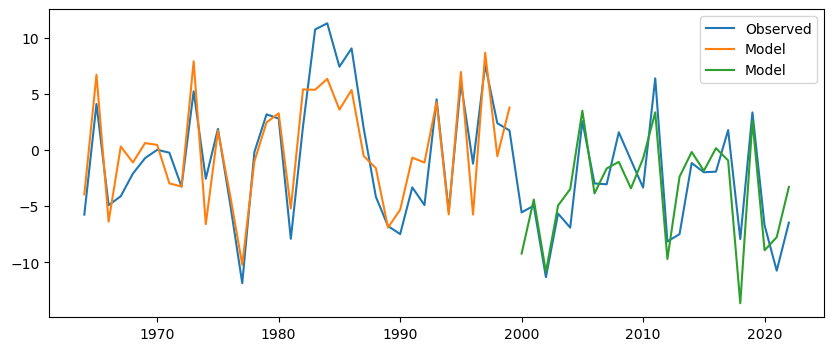

In [17]:
# plot the model time series
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df.index, df['q_anom'], label='Observed')
ax.plot(model_train.fittedvalues.index, model_train.fittedvalues, label='Model')
ax.plot(model_test.index, model_test, label='Model')
ax.legend()

Spring PET

In [18]:
# lets pull in spring PET from the ERA5 dataset
era5_pet = xr.open_dataset('../data/etdata/ERA5_pet_et_clouds.nc')
# add crs to the dataset
era5_pet = era5_pet.rio.write_crs(4326)
# reprojet to the UCRB boundary
era5_pet = era5_pet.rio.reproject(co_epsg)
# clip to the ucrb boundary
era5_pet = era5_pet.rio.clip(ucrb_basin_boundary.geometry, all_touched=True)
# convert e and pev to mm/month from -1 * m/day by multiplying by days in each month
era5_pet['month_days'] = era5_pet.time.dt.days_in_month
era5_pet['e'] = era5_pet['e'] * era5_pet['month_days'] * 1000 * -1
era5_pet['pev'] = era5_pet['pev'] * era5_pet['month_days'] * 1000 * -1
# calculate the spring totals for each year
era5_pet_spring = era5_pet.where(era5_pet.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time').pev
# replace 0 with nan
era5_pet_spring = era5_pet_spring.where(era5_pet_spring>0, np.nan)
# calculate the spatial mean
era5_pet_spring_mean = era5_pet_spring.mean(dim=['x','y']).sel(year=slice(1964,2022))


In [19]:
# let's pull in CRU ET data
cru_et = xr.open_dataset('../data/etdata/CRU_UCRB_Monthly_PET_1963_2022.nc')
# add crs to the dataset
cru_et = cru_et.rio.write_crs(4326)
# reprojet to the UCRB boundary
cru_et = cru_et.rio.reproject(co_epsg)
# clip to the ucrb boundary
cru_et = cru_et.rio.clip(ucrb_basin_boundary.geometry, all_touched=True)
# calculate the spring totals for each year
cru_et_spring = cru_et.where(cru_et.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time').pet
# replace 0 with nan
cru_et_spring = cru_et_spring.where(cru_et_spring>0, np.nan)
# calculate the spatial mean
cru_et_spring_mean = cru_et_spring.mean(dim=['x','y']).sel(year=slice(1964,2022))


Seasonal Precipitation

In [20]:
# do the same for winter
ucrb_winter_precipitation = prism_4km_all_ds.copy()
ucrb_winter_precipitation['WY'] = ucrb_winter_precipitation.month.dt.year.where(ucrb_winter_precipitation.month.dt.month<10, ucrb_winter_precipitation.month.dt.year+1)
ucrb_winter_precipitation = ucrb_winter_precipitation.where(prism_4km_all_ds.month.dt.month.isin([12,1,2]), drop=True).groupby('WY').sum(dim='month')
# fill 0 with nan
ucrb_winter_precipitation = ucrb_winter_precipitation.where(ucrb_winter_precipitation>0, np.nan)
# calculate the mean
ucrb_winter_precipitation_mean = ucrb_winter_precipitation.mean(dim=['x','y']).drop_vars('spatial_ref')
# rename WY to year
ucrb_winter_precipitation_mean = ucrb_winter_precipitation_mean.rename({'WY':'year'})

# do the same for spring
ucrb_spring_precipitation = prism_4km_all_ds.where(prism_4km_all_ds.month.dt.month.isin([3,4,5]), drop=True).groupby('month.year').sum(dim='month')
# fill 0 with nan
ucrb_spring_precipitation = ucrb_spring_precipitation.where(ucrb_spring_precipitation>0, np.nan)
# calculate the mean
ucrb_spring_precipitation_mean = ucrb_spring_precipitation.mean(dim=['x','y']).drop_vars('spatial_ref')

# do the same for summer
ucrb_summer_precipitation = prism_4km_all_ds.where(prism_4km_all_ds.month.dt.month.isin([6,7,8]), drop=True).groupby('month.year').sum(dim='month')
# fill 0 with nan
ucrb_summer_precipitation = ucrb_summer_precipitation.where(ucrb_summer_precipitation>0, np.nan)
# calculate the mean
ucrb_summer_precipitation_mean = ucrb_summer_precipitation.mean(dim=['x','y']).drop_vars('spatial_ref')

# do the same for fall
ucrb_fall_precipitation = prism_4km_all_ds.where(prism_4km_all_ds.month.dt.month.isin([9,10,11]), drop=True).groupby('month.year').sum(dim='month')
# fill 0 with nan
ucrb_fall_precipitation = ucrb_fall_precipitation.where(ucrb_fall_precipitation>0, np.nan)
# calculate the mean
ucrb_fall_precipitation_mean = ucrb_fall_precipitation.mean(dim=['x','y']).drop_vars('spatial_ref')
# make the year n+1
ucrb_fall_precipitation_mean['year'] = ucrb_fall_precipitation_mean['year'].values + 1

In [21]:
# how much of the runoff deficit is explained by the precipitation deficit
# create a dataframe with the data
df = pd.DataFrame({'p':annual_p_km3.sel(WY=slice(1964,2022))['p_km3'].values, 
                   'p_spring':ucrb_spring_precipitation_mean.sel(year=slice(1964,2022))['ppt'].values, 
                   'pet':era5_pet_spring_mean,
                   't':annual_t_mean.sel(WY=slice(1964,2022))['t_mean'].values,
                   'q':ucrb_naturalized_streamflow.loc['1964-01-01':'2022-01-01']['annual_flow_km3'].values}, index = annual_p_km3.sel(WY=slice(1964,2022)).WY.values)

# convert each value to a deficit from the mean
df['p_anom'] = (df['p'])
df['pet_anom'] = (df['pet'])
df['t_anom'] = (df['t'])
df['q_anom'] = (df['q'] - df['q'].loc[1964:2022].mean())
# run a model to see how much of the variance in q is explained by p
model_train = ols('q ~ p+pet', data=df).fit()
model_train_anom = model_train.fittedvalues - model_train.fittedvalues.mean()

# calculate the sum of the deficit over the 2000-2022 period
q_deficit = df['q_anom'].loc[2000:2022].sum()
pre_2000_q_deficit = df['q_anom'].loc[1964:1999].sum()
# calculate the sum of the model deficit over the same period
model_train_deficit = model_train_anom.loc[2000:2022].sum()
model_pre_2000_deficit = model_train_anom.loc[1964:1999].sum()
# calculate the percent of the deficit that is explained by the model
model_deficit_percent = model_train_deficit / q_deficit * 100
pre_2000_model_deficit_percent = model_pre_2000_deficit / pre_2000_q_deficit * 100
print(f'The model predicts {model_deficit_percent:.2f}% of the deficit from 2000-2022 from precipitation')
print(f'The model predicts {pre_2000_model_deficit_percent:.2f}% of the deficit from 1964-1999 from precipitation')
# print the correlation coefficient squared between p_anom and q_anom
print(f'The correlation^2 between the precipitation and streamflow is {(np.corrcoef(df.p_anom, df.q_anom)[0,1])**2:.2f}')
print(f'The correlation^2 between the spring PET and streamflow is {(np.corrcoef(df.pet_anom, df.q_anom)[0,1])**2:.2f}')
print(f'The model r2 is {model_train.rsquared:.2f}')

The model predicts 84.51% of the deficit from 2000-2022 from precipitation
The model predicts 84.51% of the deficit from 1964-1999 from precipitation
The correlation^2 between the precipitation and streamflow is 0.75
The correlation^2 between the spring PET and streamflow is 0.46
The model r2 is 0.76


The correlation^2 between the pet/p ratio and the streamflow is 0.67


Text(0.5, 1.0, 'Spring PET/P Z-score vs Streamflow  Z-score')

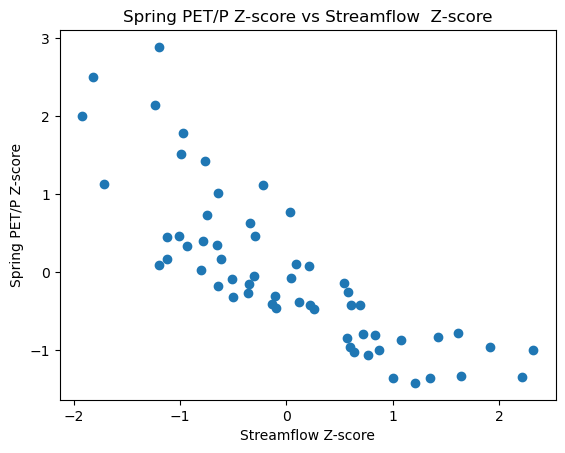

In [22]:
# calculate pet/p ratio
pet_p_zscore = ((df['pet'] / df['p']) - (df['pet'] / df['p']).mean()) / (df['pet'] / df['p']).std()
q_anom_zscore = (df['q_anom'] - df['q_anom'].mean()) / df['q_anom'].std()
# calculate the correlation between the pet/p ratio and the streamflow deficit
print(f'The correlation^2 between the pet/p ratio and the streamflow is {(np.corrcoef(pet_p_zscore, q_anom_zscore)[0,1])**2:.2f}')
# plot these against each other
fig, ax = plt.subplots()
ax.scatter(q_anom_zscore,pet_p_zscore)
ax.set_ylabel('Spring PET/P Z-score')
ax.set_xlabel('Streamflow Z-score')
ax.set_title('Spring PET/P Z-score vs Streamflow  Z-score')


Text(0.5, 0.9, 'r2 = 0.55')

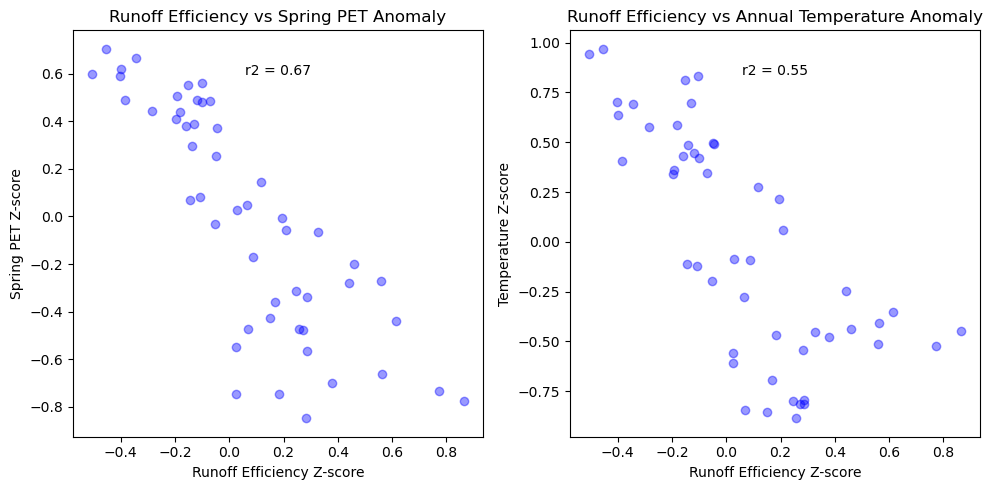

In [23]:
runoff_efficiency = (((df['q']/df['p']) - (df['q']/df['p']).mean())/(df['q']/df['p']).std()).rolling(window=10).mean().dropna()
value_pet = ((df['pet']-df['pet'].mean())/df['pet'].std()).rolling(window=10).mean().dropna()
value_t = ((df['t']-df['t'].mean())/df['t'].std()).rolling(window=10).mean().dropna()

# plot these scatter plots side by side with r value in the right corner
fig, ax = plt.subplots(1,2, figsize=(10,5), tight_layout=True)
ax[0].scatter(runoff_efficiency, value_pet, color='b', alpha=0.4)
ax[0].set_xlabel('Runoff Efficiency Z-score')
ax[0].set_ylabel('Spring PET Z-score')
ax[0].set_title('Runoff Efficiency vs Spring PET Anomaly')
ax[1].scatter(runoff_efficiency, value_t, color='b', alpha=0.4)
ax[1].set_xlabel('Runoff Efficiency Z-score')
ax[1].set_ylabel('Temperature Z-score')
ax[1].set_title('Runoff Efficiency vs Annual Temperature Anomaly')
# add r value to the top right of the plot
ax[0].text(0.5, 0.9, f'r2 = {np.corrcoef(runoff_efficiency, value_pet)[0,1]**2:.2f}', ha='center', va='center', transform=ax[0].transAxes)
ax[1].text(0.5, 0.9, f'r2 = {np.corrcoef(runoff_efficiency, value_t)[0,1]**2:.2f}', ha='center', va='center', transform=ax[1].transAxes)



### <a id='toc4_1_1_'></a>[Plot streamflow and precipitation standardized anomalies](#toc0_)

Text(0.5, 0, 'Water Year')

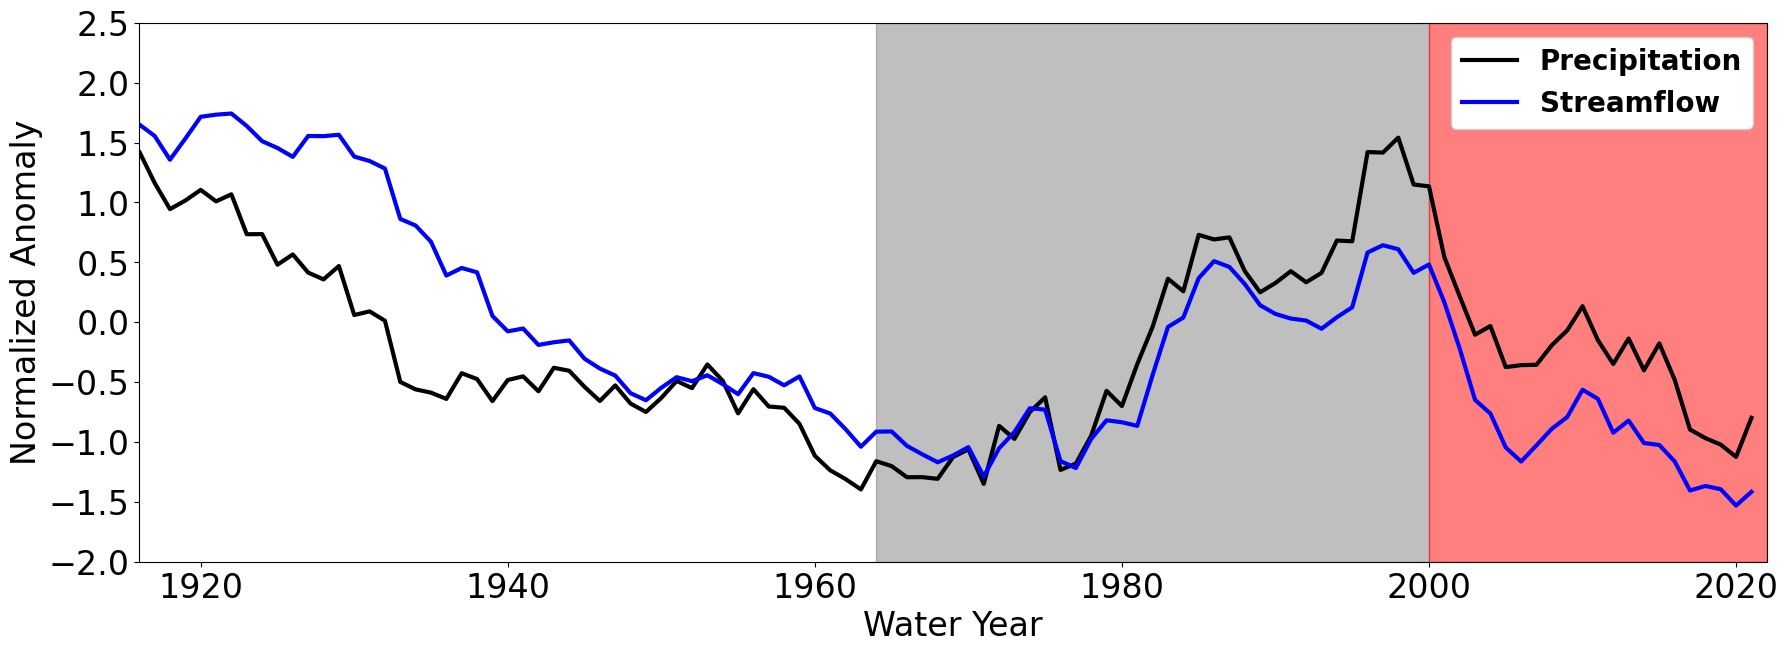

In [24]:
streamflow_vector = ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1906:2022].rolling(20,min_periods=2,).mean().values
precipitation_vector = annual_p_km3['p_km3'].loc[1906:2022].rolling({'WY':20},min_periods=2).mean().values
# normalize vectors
norm_anom_streamflow = (streamflow_vector-np.nanmean(streamflow_vector))/np.nanstd(streamflow_vector)
norm_anom_precipitation = (precipitation_vector-np.nanmean(precipitation_vector))/np.nanstd(precipitation_vector)
plt.figure(figsize=(21,7))
plt.plot(np.arange(1905,2022,1),norm_anom_precipitation, label='Precipitation', lw=3, color='k')
plt.plot(np.arange(1905,2022,1),norm_anom_streamflow, label='Streamflow', lw=3, color='b')
# shade baseline perid
plt.axvspan(1964, 2000, alpha=0.5, color='grey')
# shade Millennium Drought
plt.axvspan(2000, 2022, alpha=0.5, color='red')
plt.ylim(-2,2.5)
plt.xlim(1916, 2022)
plt.xlabel('Year')
plt.legend()
#increase y-axis tick label size
# make y-ticks everyy 
plt.yticks(size=24);
plt.xticks(size=24);
plt.legend(loc='upper right',
           framealpha=1, 
           ncols=1, 
           prop={'weight':'bold',
                 'size':20})

plt.ylabel('Normalized Anomaly', color='black', size=24)
plt.xlabel('Water Year', color='black', size=24)

In [27]:
# calcualte the rolling averge of streamflow anomaly over the mean
mean_q = ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1950:1999].mean()
mean_p = annual_p_km3['p_km3'].loc[1950:1999].mean()
# calculate standard deviation of streamflow anomaly
std_q = ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1950:1999].std()
std_p = annual_p_km3['p_km3'].loc[1950:1999].std()
# calculate the percent above or below normal (100%
streamflow_std_norm = pd.DataFrame(((ucrb_naturalized_streamflow_tmp['annual_flow_km3'] - mean_q) / std_q) )
precipitation_std_norm = (((annual_p_km3['p_km3'] - mean_p) / std_p) ).to_dataframe()
# reindex
streamflow_std_norm.index = pd.to_datetime(streamflow_std_norm.index, format='%Y')
precipitation_std_norm.index = pd.to_datetime(precipitation_std_norm.index, format='%Y')
# calculate the rolling average of the percent above or below mean
# streamflow_std_norm = streamflow_std_norm.resample('20Y').mean()
# precipitation_std_norm = precipitation_std_norm.resample('20Y').mean()
streamflow_rolling = streamflow_std_norm.rolling(15, min_periods=5, closed='neither').mean()
precipitation_rolling = precipitation_std_norm.rolling(15, min_periods=5, closed='neither').mean()
# caclulate streamflow sensitivity 



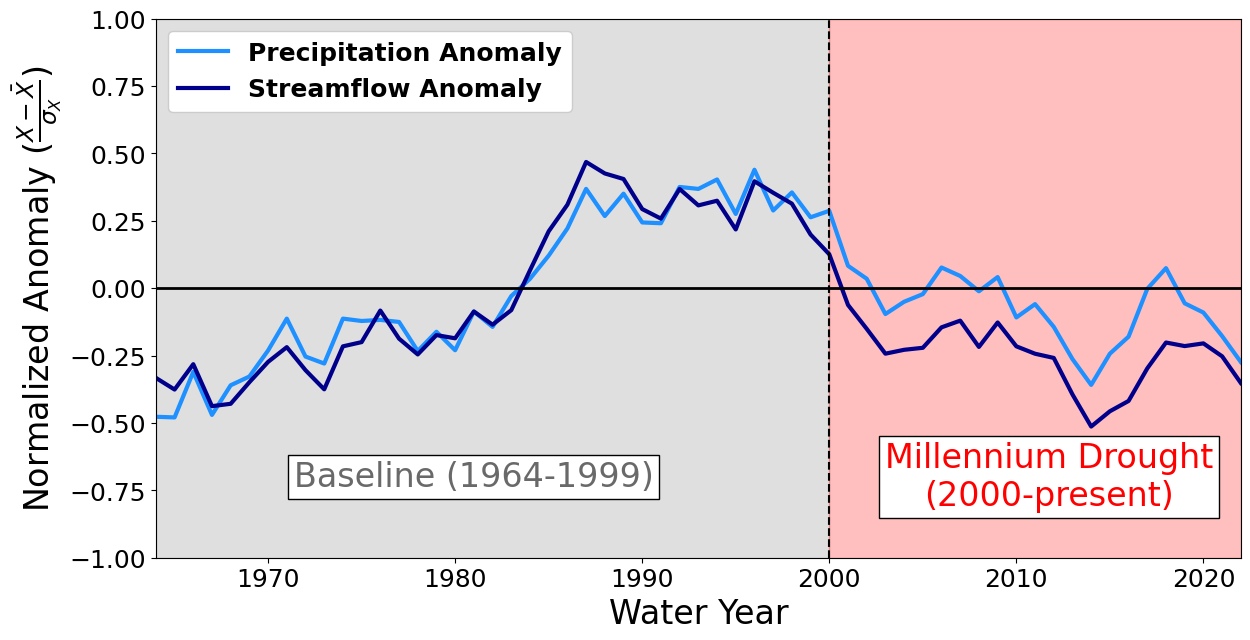

In [33]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(precipitation_rolling.index, 
        precipitation_rolling['p_km3'], 
        color='dodgerblue', 
        lw=3, 
        label='Precipitation Anomaly')
ax.plot(streamflow_rolling.index, 
        streamflow_rolling['annual_flow_km3'], 
        color='darkblue', 
        lw=3, 
        label='Streamflow Anomaly')
ax.set_ylabel('Normalized Anomaly '+r'($\frac{X-\bar{X}}{\sigma_X}$)', color='black', size=24)
ax.set_xlabel('Water Year', color='black', size=24)
# ax.set_title('UCRB Annual Streamflow and Precipitation\nNormalized Anomalies (1964-2022)\n10-year rolling average', size=24)
ax.set_xlim([dt.datetime(1964,1,1), dt.datetime(2022,1,1)])
ax.set_ylim(-1,1)
ax.axhline(0, color='k', ls='-', lw=2)
# draw vertical line at 2000
ax.axvline(dt.datetime(2000,1,1), color='k', ls='--')
# shade baseline perid
ax.axvspan(dt.datetime(1964,1,1), dt.datetime(1999,12,31), alpha=0.25, color='grey')
# shade Millennium Drought
ax.axvspan(dt.datetime(2000,1,1), dt.datetime(2022,1,1), alpha=0.25, color='red')
# # hatch the difference between the two lines
# ax.fill_between(streamflow_rolling.index, streamflow_rolling['annual_flow_km3'], 
#                 precipitation_rolling['p_km3'], 
#                 where=streamflow_rolling['annual_flow_km3'] < precipitation_rolling['p_km3'], 
#                 facecolor='red', 
#                 hatch='///',
#                 alpha=0.2, 
#                 interpolate=True,
#                 label='Precipitation Anomaly > Streamflow Anomaly')
# increase y-axis tick label size
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(loc='upper left',
              framealpha=1, 
              ncols=1, 
              prop={'weight':'bold',
                  'size':18})
# mark the millennium drought with text
ax.text(dt.datetime(2011,10,1), 
        -0.7, 
        'Millennium Drought\n(2000-present)', 
        # add white text box around the text
        bbox=dict(facecolor='white', alpha=1, edgecolor='k'),
        ha='center',
        va='center',
        color='r',
        size=24)
# mark the baseline period with text
ax.text(dt.datetime(1981,1,1), 
        -0.7, 
        'Baseline (1964-1999)', 
        # add white text box around the text
        bbox=dict(facecolor='white', alpha=1, edgecolor='k'),
        ha='center',
        va='center',
        color='dimgrey',
        size=24)
# make sure the entire plot is printed

# save at 600 dpi 
# plt.savefig('../figures/ucrb_streamflow_precipitation_normalized_anomalies.png', dpi=600)

### <a id='toc4_1_2_'></a>[Figure 1 A Plot within Manuscript](#toc0_)

In [57]:
# Function used for adding intervals to the plot
def add_interval(ax, xdata, ydata, color, caps="  "):
    line = ax.add_line(mpl.lines.Line2D(xdata, ydata, color=color, linewidth=3))
    anno_args = {
        'ha': 'center',
        'va': 'center',
        'size': 24,
        'color': line.get_color(),
    }
    a0 = ax.annotate(caps[0], xy=(xdata[0], ydata[0]), **anno_args)
    a1 = ax.annotate(caps[1], xy=(xdata[1], ydata[1]), **anno_args)
    return (line,(a0,a1))

Text(0.5, 0, 'Water Year')

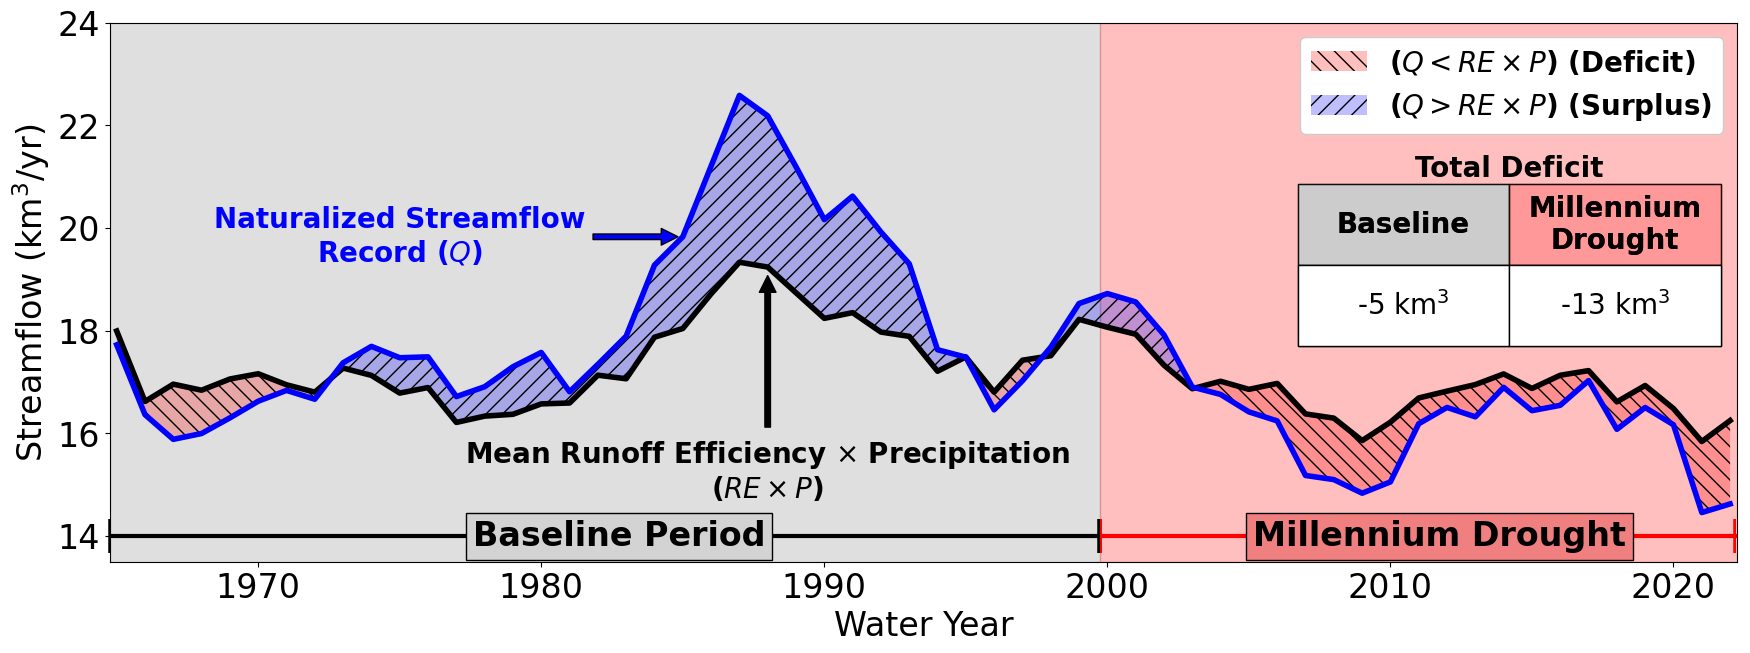

In [58]:
fig, ax = plt.subplots(figsize=(21,7))
runoff_ratio = 0.15*(annual_p_km3['p_km3'].sel(WY=slice(1964,2022)))
# plot line of P*runoff ratio
plt.plot(ucrb_naturalized_streamflow.loc[dt.date(1964,1,1):dt.date(2022,1,1)].index,
         runoff_ratio.rolling({'WY':10},min_periods=2).mean() , 
         color='k', 
         lw=4, 
         )
# plot naturalized streamflow
plt.plot(ucrb_naturalized_streamflow.loc[dt.date(1964,1,1):dt.date(2022,1,1)].index,
         ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean(), 
         color='blue', 
         lw=4, 
         )

# hatch between two plots
plt.fill_between(ucrb_naturalized_streamflow.loc[dt.date(1964,1,1):dt.date(2022,1,1)].index,
                 runoff_ratio.rolling({'WY':10},min_periods=2).mean(),
                 ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean(), 
                 where=runoff_ratio.rolling({'WY':10},min_periods=2).mean()>=ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean(), 
                 facecolor='red', 
                 hatch='\\\\',
                 alpha=0.25, 
                 interpolate=True,
                 label=r'($Q < RE \times P$) (Deficit)')
plt.fill_between(ucrb_naturalized_streamflow.loc[dt.date(1964,1,1):dt.date(2022,1,1)].index,
                 runoff_ratio.rolling({'WY':10},min_periods=2).mean() ,
                 ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean(), 
                 where=runoff_ratio.rolling({'WY':10},min_periods=2).mean()<ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean(), 
                 facecolor='blue',
                 hatch='//', 
                 alpha=0.25, 
                 interpolate=True,
                 label=r'($Q > RE \times P$) (Surplus)')

# plt.ylim(runoff_ratio.rolling(10).mean().mean()-0.05,runoff_ratio.rolling(10).mean().mean()+0.05)
plt.axvspan(dt.date(1999,10,1),dt.date(2022,10,1),color='red',alpha=0.25,zorder=0)
# add a text box to label this span as the "Baseline Period"
plt.text(dt.date(2011,10,1), 14, 
        'Millennium Drought', 
        fontsize=24, 
        color='black', 
        ha='center', va='center', 
        fontweight='bold', 
        bbox={'facecolor':'lightcoral', 'pad':5})
# draw a horizontal line between the start and end of the baseline period
add_interval(ax,(dt.date(1999,10,1),dt.date(2022,3,1)),(14,14),'red', caps='||')
# add a text box to label this span as the "Baseline Period"
plt.text(dt.date(1982,10,1), 14, 
         'Baseline Period',
          fontsize=24, 
          color='black',
          backgroundcolor='lightgray', 
          ha='center', va='center',
          fontweight='bold', 
          bbox={'facecolor':'lightgray', 'pad':5})
# draw a horizontal line between the start and end of the baseline period
add_interval(ax,(dt.date(1964,10,1),dt.date(1999,9,1)),(14,14),'black', caps='||')
plt.axvspan(dt.date(1964,10,1),dt.date(1999,10,1),color='grey',alpha=0.25, zorder=0)

# add a horizontal line at the minimum of streaflow during the baseline period
diff_baseline = (runoff_ratio.rolling({'WY':10},min_periods=2).mean() - ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean()).sel(WY=slice(1964,1999))
total_diff_baseline = diff_baseline.where(diff_baseline>0).sum()
total_surplus_baseline= diff_baseline.where(diff_baseline<0).sum()
        
# add a horizontal line at the minimum of streamflow during the Millennium Drought
diff_md = (runoff_ratio.rolling({'WY':10},min_periods=2).mean() - ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean()).sel(WY=slice(2000,2022))   
total_diff_md = diff_md.where(diff_md>0).sum()
total_surplus_md= diff_md.where(diff_md<0).sum()

######## Table Formatting ########
col_labels=['Baseline','Millennium\nDrought']
row_labels=['Total Deficit']#,'Total Surplus']
table_vals=[[
            '{:.0f} km$^3$'.format(-total_diff_baseline),
            '{:.0f} km$^3$'.format(-total_diff_md)],
            ]#[
        #     '{:.0f} km$^3$'.format(-total_surplus_baseline),
        #     '{:.0f} km$^3$'.format(-total_surplus_md)
        #     ]]
# hidden table to help with transparency
hidden_table = plt.table(cellText=table_vals,
                  colWidths = [0.1]*2,
                #   rowLabels=row_labels,
                  colLabels=col_labels,
                  bbox=[0.73, 0.4, 0.26, 0.3],
                  cellLoc='center',
                  rowLoc='center')

# bold the column and row labels
for (row, col), cell in hidden_table.get_celld().items():
  if (row == 0) or (col == -1):
    cell.set_text_props(fontproperties=FontProperties(weight='bold'))
hidden_table.auto_set_font_size(False)
hidden_table.set_fontsize(20)
hidden_table.scale(1.5, 4.2)
# table with data
the_table = plt.table(cellText=table_vals,
                  colWidths = [0.1]*2,
                #   rowLabels=row_labels,
                  colLabels=col_labels,
                  bbox=[0.73, 0.4, 0.26, 0.3],
                  cellLoc='center',
                  rowLoc='center',
                  colColours=['grey','red'])
# bold the column and row labels
for (row, col), cell in the_table.get_celld().items():
  if (row == 0) or (col == -1):
    cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    cell.set_alpha(0.4)
the_table.auto_set_font_size(False)
the_table.set_fontsize(20)
the_table.scale(1.5, 4.2)
# add title as text above table
plt.text((0.73+.99)/2, 0.73, 'Total Deficit',
        fontsize=20, color='black',
        fontweight='bold',
        ha='center', va='center',
        transform=ax.transAxes)

# add an arrow and point to mean runoff efficiency line
plt.annotate(r'Mean Runoff Efficiency $\times$ Precipitation'+'\n'+r'($RE \times P$)',
                xy=(dt.date(1988,1,1),runoff_ratio.rolling({'WY':10},min_periods=2).mean().sel(WY=1988).values),
                xytext=(dt.date(1988,1,1),runoff_ratio.rolling({'WY':10},min_periods=2).mean().sel(WY=1988).values-4.5),
                # center text
                ha='center',
                # increase text size
                size=20,
                # bold text
                weight='bold',
                # set arrow properties
                arrowprops=dict(facecolor='black', shrink=0.05),
                )
# add an arrow and point to mean runoff efficiency line
plt.annotate('Naturalized Streamflow\nRecord '+r'($Q$)',
                xy=(dt.date(1985,1,1),ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean().loc[1985]),
                xytext=(dt.date(1975,1,1),ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean().loc[1985]),
                # center text
                ha='center',
                va='center',
                # increase text size
                size=20,
                # bold text
                weight='bold',
                color='blue',
                # set arrow properties
                arrowprops=dict(facecolor='blue', shrink=0.05),
                )
                  
plt.xlim(dt.date(1964,10,1),dt.date(2022,4,1))
#increase y-axis tick label size
plt.yticks(size=24);
plt.xticks(size=24);
plt.legend(loc='upper right',
           framealpha=1, 
           ncols=1, 
           prop={'weight':'bold',
                 'size':20})
plt.ylim(13.5,24)
plt.ylabel('Streamflow (km$^3$/yr)', color='black', size=24)
plt.xlabel('Water Year', color='black', size=24)
# add title saying "15-year Rolling Mean UCRB Runoff Ratio"
# plt.title('UCRB Naturalized Streamflow and Runoff Efficiency * Precipitation\n10-year Rolling Mean', size=16)
# save figure at 700 dpi and 9x6 centimeters
# fig.savefig('../figures/precip_deficit_streamflow_deficit.svg', dpi=700, pad_inches=0.1)

### <a id='toc4_1_3_'></a>[Streamflow, Precipitation, Temperature Figure used in Supplemental Text](#toc0_)

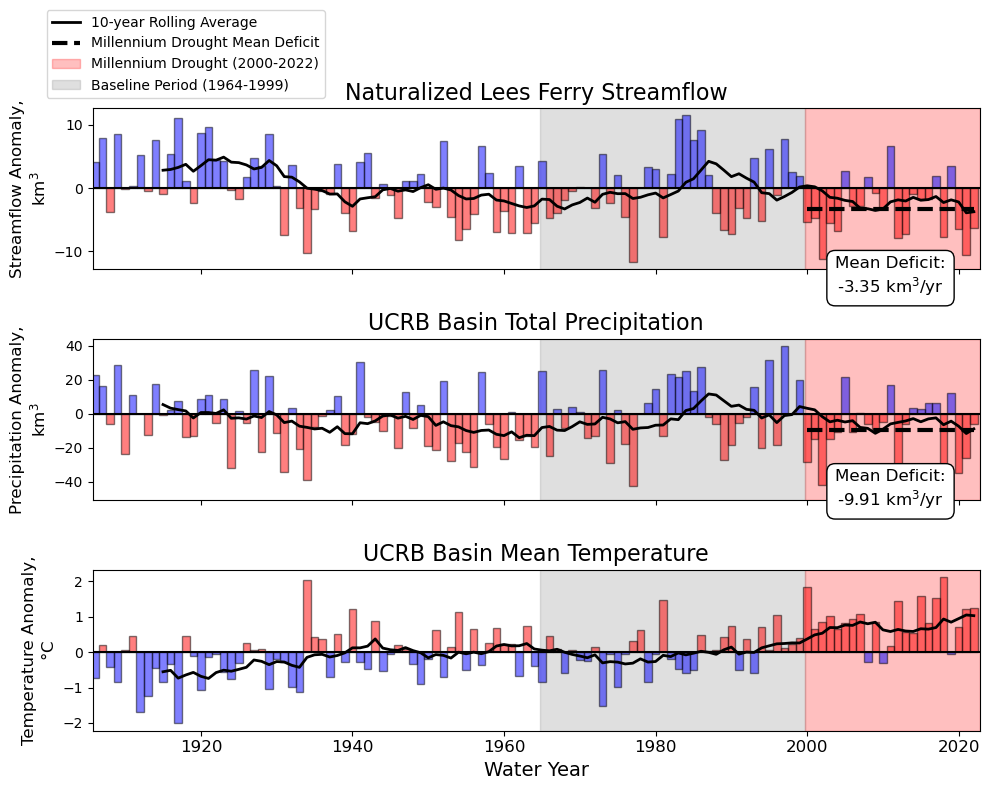

In [59]:
plt.style.use('default')
all_dates = pd.date_range('1895-10-01','2022-10-01', freq='1Y')
fig, axs = plt.subplots(nrows=3, figsize=(10,8), tight_layout=True, sharex=True)

ax = axs[0]
flow_anomaly = ucrb_naturalized_streamflow['annual_flow_km3']-ucrb_naturalized_streamflow['annual_flow_km3'].loc[dt.date(1963,1,1):dt.date(1999,1,1)].mean()
# create a linear regression for the flow_anomaly
slope1, intercept1, _,_,_ = stats.linregress(flow_anomaly.index.year,flow_anomaly.values)
# add bar plot of ucrb_naturalized_streamflow[annual_flow_km3]
ax.bar(flow_anomaly[flow_anomaly>=0].index, flow_anomaly[flow_anomaly>=0], width=365.25, color='blue',ec='k', alpha=0.5)
ax.bar(flow_anomaly[flow_anomaly<0].index, flow_anomaly[flow_anomaly<0], width=365.25, color='red',ec='k', alpha=0.5)
# add a 10 year moving average line to the plot
ax.plot(flow_anomaly.index, flow_anomaly.rolling(10).mean(), color='k', linewidth=2, label='10-year Rolling Average')
# add a trend line to the plot
# ax.plot(flow_anomaly.index , slope1*flow_anomaly.index.year + intercept1, ls='--',color='k', label='Best Fit Line', lw=2)

# runoff_ratio = ucrb_naturalized_streamflow_tmp['annual_flow_km3']/annual_p_km3['p_km3'].sel(WY=slice(1906,2022))

# ax3.plot(ucrb_naturalized_streamflow.index,runoff_ratio.rolling(10).mean(), color='k', lw=2, ls='dotted')
# ax3.set_ylabel('Runoff Ratio', color='black', size=12)
# ax3.set_ylim(runoff_ratio.rolling(10).mean().mean()-0.05,runoff_ratio.rolling(10).mean().mean()+0.05)
# # set ax3 y-ticks to be rounded to 2 decimal places
# ax3.set_yticklabels([f"{i:.2f}" for i in ax3.get_yticks()])
# ax3.tick_params(axis='y', labelcolor='black', labelsize=12)
# add a horizontal line for the mean flow anomaly from 2000-2022 spanning the years 2000-2022
ax.plot([dt.date(2000,1,1), dt.date(2022,1,1)],
        [flow_anomaly.loc[dt.date(2000,1,1):dt.date(2022,1,1)].mean(),flow_anomaly.loc[dt.date(2000,1,1):dt.date(2022,1,1)].mean()],
        color='k', ls='--', lw=3, label='Millennium Drought Mean Deficit')
# add a text box for the value of the flow anomaly from 2000-2022
ax.text(dt.date(2011,1,1), -14,
        f"Mean Deficit:\n{flow_anomaly.loc[dt.date(2000,1,1):dt.date(2022,1,1)].mean():.2f} km$^3$/yr", size=12,
        verticalalignment='center', horizontalalignment='center',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# add a 0 line
ax.axhline(0, color='k')
# set the labels
ax.set_ylabel('Streamflow Anomaly,\nkm$^3$', size=12)
ax.set_title('Naturalized Lees Ferry Streamflow', size=16)
ax.set_xlim()

# plot precipitation
ax = axs[1]
precip_anomaly = (annual_p_km3['p_km3'].sel(WY=slice(1906,2022))-annual_p_km3['p_km3'].sel(WY=slice(1963,1999)).mean()).to_pandas()
precip_anomaly_with_dates = precip_anomaly.copy()
precip_anomaly_with_dates.index = all_dates[10:]
# create a linear regression for the precip_anomaly
slope2, intercept2, _,_,_ = stats.linregress(precip_anomaly.index,precip_anomaly)

# add bar plot of ucrb_naturalized_streamflow[annual_flow_km3]
ax.bar(precip_anomaly_with_dates[precip_anomaly_with_dates>=0].index, precip_anomaly[precip_anomaly>=0], width=365.25, color='blue',ec='k', alpha=0.5)
ax.bar(precip_anomaly_with_dates[precip_anomaly_with_dates<0].index, precip_anomaly[precip_anomaly<0], width=365.25, color='red',ec='k', alpha=0.5)
# add a 10 year moving average line to the plot
ax.plot(all_dates[10:], precip_anomaly.rolling(10).mean(), color='k', linewidth=2, label='10-year Rolling Average')
# add a trend line to the plot
# ax.plot(all_dates[10:], slope2*precip_anomaly.index + intercept2, ls='--',color='k', label='Best Fit Line', lw=2)
# add a horizontal line for the mean flow anomaly from 2000-2022 spanning the years 2000-2022
ax.plot([dt.date(2000,1,1), dt.date(2022,1,1)],
        [precip_anomaly.loc[2000:2022].mean(),precip_anomaly.loc[2000:2022].mean()],
        color='k', ls='--', lw=3, label='Millennium Drought Mean Deficit')
# add a text box for the value of the flow anomaly from 2000-2022
ax.text(dt.date(2011,1,1), -45,
        f"Mean Deficit:\n{precip_anomaly.loc[2000:2022].mean():.2f} km$^3$/yr", size=12,
        verticalalignment='center', horizontalalignment='center',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
# add a 0 line
ax.axhline(0, color='k')
# set the labels
ax.set_ylabel('Precipitation Anomaly,\nkm$^3$', size=12)
ax.set_title('UCRB Basin Total Precipitation',size=16)

# plot temperature
ax = axs[2]
temp_anomaly = (annual_t_mean['t_mean'].sel(WY=slice(1906,2022))-annual_t_mean['t_mean'].sel(WY=slice(1963,1999)).mean()).to_pandas()
temp_anomaly_with_dates = temp_anomaly.copy()
temp_anomaly_with_dates.index = all_dates[10:]
# create a linear regression for the temp_anomaly
slope3, intercept3, _,_,_ = stats.linregress(temp_anomaly.index,temp_anomaly)

# add bar plot of temp_anomaly
ax.bar(temp_anomaly_with_dates[temp_anomaly_with_dates>=0].index, temp_anomaly[temp_anomaly>=0], width=365.25, color='red',ec='k', alpha=0.5)
ax.bar(temp_anomaly_with_dates[temp_anomaly_with_dates<0].index, temp_anomaly[temp_anomaly<0], width=365.25, color='blue',ec='k', alpha=0.5)
# add a 10 year moving average line to the plot
ax.plot(all_dates[10:], temp_anomaly.rolling(10).mean(), color='k', linewidth=2, label='10-year Rolling Average')
# add a trend line to the plot
# ax.plot(all_dates[10:], slope3*temp_anomaly.index + intercept3, ls='--',color='k', label='Best Fit Line', lw=2)
# add a 0 line
ax.axhline(0, color='k')
# set the labels
ax.set_ylabel('Temperature Anomaly,\n$\degree$C', size=12)
ax.set_title('UCRB Basin Mean Temperature', size=16)
ax.set_xlabel('Water Year', size=14)
# increase the size of the x-axis tick labels
ax.tick_params(axis='x', which='major', labelsize=12)
for ax in axs:
    ax.axvspan(dt.date(1999,10,1),dt.date(2022,10,1),color='red',alpha=0.25, label='Millennium Drought (2000-2022)',zorder=0)
    ax.axvspan(dt.date(1964,10,1),dt.date(1999,10,1),color='grey',alpha=0.25, label='Baseline Period (1964-1999)',zorder=0)
    ax.set_xlim(dt.date(1905,10,1),dt.date(2022,10,1))
    
    # create a new legend for the vertical lines
    ax2 = ax.twinx()
    # add a vertical line at 2000 and label start of millennium drought
#     ax2.axvline(dt.date(1999,10,1), color='magenta', ls='--', lw=2, label='Millennium Drought Onset')
    # add a vertical line at 1962 and label Lake Powell filling
#     ax2.axvline(dt.date(1964,10,1), color='magenta', ls=':', lw=2,  label='Lake Powell Filling')
    # add a vertical line at 1922 and label Colorado River Compact
#     ax2.axvline(dt.date(1922,10,1), color='magenta', ls='-.', lw=2,  label='Colorado River Compact')
    ax2.axis('off')
    
    if ax == axs[0]:
        ax.legend(bbox_to_anchor=(-0.06, 1.02, 1, 0.2), loc="lower left",)  
        # ax2.legend(bbox_to_anchor=(1, 1.02), loc="lower right",)

# <a id='toc5_'></a>[Let's change to focusing on our HCDN basins](#toc0_)

Pull in the HCDN basins as a geodataframe

In [60]:
selected_hcdn_basins = gpd.read_file('../data/geodata/ucrb_selected_basins.geojson')
selected_hcdn_basins_reindexed = selected_hcdn_basins.set_index('STAID')

Create a data array to add in the basin area to our dataset

In [61]:
area_da = selected_hcdn_basins_reindexed['AREA'].to_xarray()
area_da = area_da.rename({'STAID':'site_no'})

Then add this to a data array to pull into our entire dataset

In [62]:
elevation_da = selected_hcdn_basins_reindexed['mean_elevation'].to_xarray()
elevation_da.name='mean_elevation'
elevation_da = elevation_da.rename({'STAID':'site_no'})

Derive basin elevation ranges

In [63]:
elevation_range_da = (selected_hcdn_basins_reindexed['max_elevation'] - selected_hcdn_basins_reindexed['min_elevation']).to_xarray()
elevation_range_da.name='elevation_range'
elevation_range_da = elevation_range_da.rename({'STAID':'site_no'})

Add elevation categories

In [64]:
eleavtion_cat_da = selected_hcdn_basins_reindexed['elevation_category'].to_xarray()
eleavtion_cat_da.name='elevation_category'
eleavtion_cat_da = eleavtion_cat_da.rename({'STAID':'site_no'})

Add annual precipitation and seasonal precipitation

In [65]:
# add water year to the prism dataset
prism_4km_all_ds['water_year'] = prism_4km_all_ds.month.dt.year.where(prism_4km_all_ds.month.dt.month < 10, prism_4km_all_ds.month.dt.year + 1)
# # calculate the mean annual precipitation for each basin
prism_4km_annual_precipitation = prism_4km_all_ds.groupby('water_year').sum(dim='month')['ppt']
# replace 0 with nan
prism_4km_annual_precipitation = prism_4km_annual_precipitation.where(prism_4km_annual_precipitation > 0, np.nan)
# write crs to 32613 for all datasets needed
prism_4km_annual_precipitation = prism_4km_annual_precipitation.rio.set_crs(32613)
ucrb_winter_precipitation = ucrb_winter_precipitation.rio.write_crs(32613)
ucrb_spring_precipitation = ucrb_spring_precipitation.rio.write_crs(32613)
ucrb_summer_precipitation = ucrb_summer_precipitation.rio.write_crs(32613)
ucrb_fall_precipitation = ucrb_fall_precipitation.rio.write_crs(32613)
# calculate the mean wy and seasonal precipitation for each basin
wy_ppt_ds_dict = {}
winter_ppt_ds_dict = {}
spring_ppt_ds_dict = {}
summer_ppt_ds_dict = {}
fall_ppt_ds_dict = {}
# loop through each basin
for basin in selected_hcdn_basins.STANAME:
    # get the basin shape
    basin_shape = selected_hcdn_basins[selected_hcdn_basins.STANAME == basin]
    # mask the prism data to the basin
    masked_annual_prism = prism_4km_annual_precipitation.rio.clip(basin_shape.geometry, all_touched=True)
    masked_winter_prism = ucrb_winter_precipitation.rio.clip(basin_shape.geometry, all_touched=True)
    masked_spring_prism = ucrb_spring_precipitation.rio.clip(basin_shape.geometry, all_touched=True)
    masked_summer_prism = ucrb_summer_precipitation.rio.clip(basin_shape.geometry, all_touched=True)
    masked_fall_prism = ucrb_fall_precipitation.rio.clip(basin_shape.geometry, all_touched=True)
    # calculate the mean annual precipitation for the basin
    wy_ppt_ds_dict[basin_shape['STAID'].iloc[0]] = masked_annual_prism.mean(dim=['x','y'])
    winter_ppt_ds_dict[basin_shape['STAID'].iloc[0]] = masked_winter_prism.mean(dim=['x','y']).ppt
    spring_ppt_ds_dict[basin_shape['STAID'].iloc[0]] = masked_spring_prism.mean(dim=['x','y']).ppt
    summer_ppt_ds_dict[basin_shape['STAID'].iloc[0]] = masked_summer_prism.mean(dim=['x','y']).ppt
    fall_ppt_ds_dict[basin_shape['STAID'].iloc[0]] = masked_fall_prism.mean(dim=['x','y']).ppt
# create a dataset from the dictionaries
wy_ppt_ds = xr.Dataset(wy_ppt_ds_dict).to_array()
winter_ppt_ds = xr.Dataset(winter_ppt_ds_dict).to_array()
spring_ppt_ds = xr.Dataset(spring_ppt_ds_dict).to_array()
summer_ppt_ds = xr.Dataset(summer_ppt_ds_dict).to_array()
fall_ppt_ds = xr.Dataset(fall_ppt_ds_dict).to_array()
# rename the variable to site_no
wy_ppt_ds = wy_ppt_ds.rename({'variable':'site_no'}).sel(water_year=slice(1964,2022))
winter_ppt_ds = winter_ppt_ds.rename({'variable':'site_no', 'WY':'water_year'}).sel(water_year=slice(1964,2022))
spring_ppt_ds = spring_ppt_ds.rename({'variable':'site_no', 'year':'water_year'}).sel(water_year=slice(1964,2022))
summer_ppt_ds = summer_ppt_ds.rename({'variable':'site_no', 'year':'water_year'}).sel(water_year=slice(1964,2022))
fall_ppt_ds = fall_ppt_ds.rename({'variable':'site_no', 'year':'water_year'}).sel(water_year=slice(1964,2022))
# rename each appropriately
wy_ppt_ds.name = 'wy_ppt'
winter_ppt_ds.name = 'winter_ppt'
spring_ppt_ds.name = 'spring_ppt'
summer_ppt_ds.name = 'summer_ppt'
fall_ppt_ds.name = 'fall_ppt'

Pull in our HCDN flow data and convert to mm per day units

In [66]:
# download data if not downloaded yet
if not os.path.exists('../data/streamflowdata/selected_hcdn_streamflow.nc'):
    hcdn_streamflow_daily_df = nwis.get_record(sites=selected_hcdn_basins.STAID.to_list(), service='dv', start='1963-10-01', end='2022-09-30')
    hcdn_streamflow_daily_df = hcdn_streamflow_daily_df.reset_index()
    # convert datetime to numpy datetime64
    hcdn_streamflow_daily_df['datetime'] = hcdn_streamflow_daily_df.datetime.values.astype('datetime64[D]')
    hcdn_streamflow_daily_df = hcdn_streamflow_daily_df.set_index(['site_no','datetime'])
    hcdn_streamflow_daily_ds = hcdn_streamflow_daily_df['00060_Mean'].to_xarray()
    # convert from cubic feet per second to cubic meters per second
    hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds * 0.0283168
    # convert from cubic meters per second to cubic meters per day
    hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds * 86400
    # convert datetime to ns precision
    hcdn_streamflow_daily_ds['datetime'] = pd.to_datetime(hcdn_streamflow_daily_ds.datetime.values)
    hcdn_streamflow_daily_ds.to_netcdf('../data/streamflowdata/selected_hcdn_streamflow.nc')
else:
    hcdn_streamflow_daily_ds = xr.open_dataset('../data/streamflowdata/selected_hcdn_streamflow.nc')

In [67]:
# add a water year variable to the streamflow dataset
hcdn_streamflow_daily_ds['water_year'] = hcdn_streamflow_daily_ds.datetime.dt.year.where(hcdn_streamflow_daily_ds.datetime.dt.month < 10, hcdn_streamflow_daily_ds.datetime.dt.year + 1)
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.rename({'00060_Mean':'daily_q'})

In [69]:
# merge datasets
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.merge(area_da)
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.merge(elevation_da)
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.merge(elevation_range_da)
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.merge(eleavtion_cat_da)
# Calculate flow rates in terms of basin-normalized mm/day from cubic meters per day
hcdn_streamflow_daily_ds['q_mm_day'] = hcdn_streamflow_daily_ds['daily_q'] * 1000 / hcdn_streamflow_daily_ds.AREA
# Save new daily dataset 
hcdn_streamflow_daily_ds.to_netcdf('../data/streamflowdata/selected_hcdn_basin_chars_and_daily_q.nc')

In [48]:
# groupby water year
hcdn_streamflow_annual_da = hcdn_streamflow_daily_ds.groupby('water_year').sum(dim='datetime')['q_mm_day'].where(hcdn_streamflow_daily_ds['q_mm_day'].groupby(hcdn_streamflow_daily_ds.water_year).count()>350, np.nan)
# units are in mm per year
hcdn_streamflow_annual_da.name = 'wy_q_mm'
# convert to dataset
hcdn_streamflow_annual_ds = hcdn_streamflow_annual_da.to_dataset()
# add precip to annual flows
hcdn_streamflow_annual_ds = hcdn_streamflow_annual_ds.merge(wy_ppt_ds)
hcdn_streamflow_annual_ds = hcdn_streamflow_annual_ds.merge(winter_ppt_ds)
hcdn_streamflow_annual_ds = hcdn_streamflow_annual_ds.merge(spring_ppt_ds)
hcdn_streamflow_annual_ds = hcdn_streamflow_annual_ds.merge(summer_ppt_ds)
hcdn_streamflow_annual_ds = hcdn_streamflow_annual_ds.merge(fall_ppt_ds)
# add elevation and area to annual flows
hcdn_streamflow_annual_ds = hcdn_streamflow_annual_ds.merge(elevation_da)
hcdn_streamflow_annual_ds = hcdn_streamflow_annual_ds.merge(elevation_range_da)
hcdn_streamflow_annual_ds = hcdn_streamflow_annual_ds.merge(eleavtion_cat_da)
hcdn_streamflow_annual_ds = hcdn_streamflow_annual_ds.merge(area_da)
# save to netcdf
hcdn_streamflow_annual_ds.to_netcdf('../data/streamflowdata/selected_hcdn_streamflow_annual.nc')

Create a simple plot of basin-to-basin correlation of spring+summer mean streamflow

<Axes: xlabel='site_no', ylabel='site_no'>

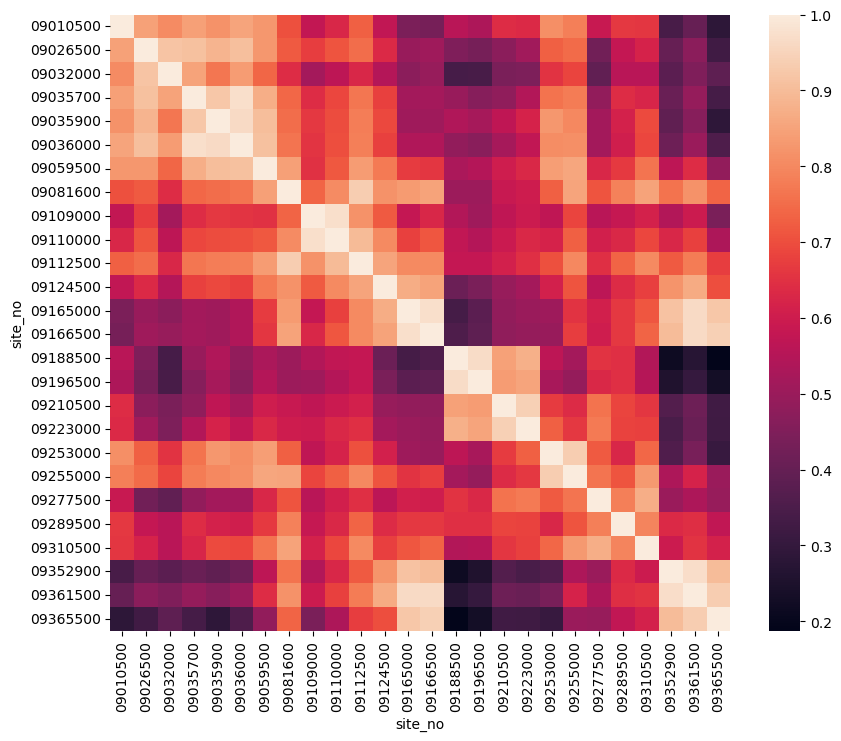

In [70]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(hcdn_streamflow_annual_ds['wy_q_mm'].to_pandas().corr(), ax=ax)

# <a id='toc6_'></a>[Cumulative Streamflow Deficit Plots](#toc0_)

In [65]:
rolling_windows = np.arange(1,21,1)
rolling_vals = {}
min_start_year = []
for window in rolling_windows:
    rolling_vals[window] = ucrb_naturalized_streamflow['annual_flow_km3'].rolling(window, center=False).mean()
    # append 1 year before the rolling_vals[window].idxmin()
    min_start_year.append(rolling_vals[window].idxmin() - pd.DateOffset(years=1))

(3.0, 30.0)

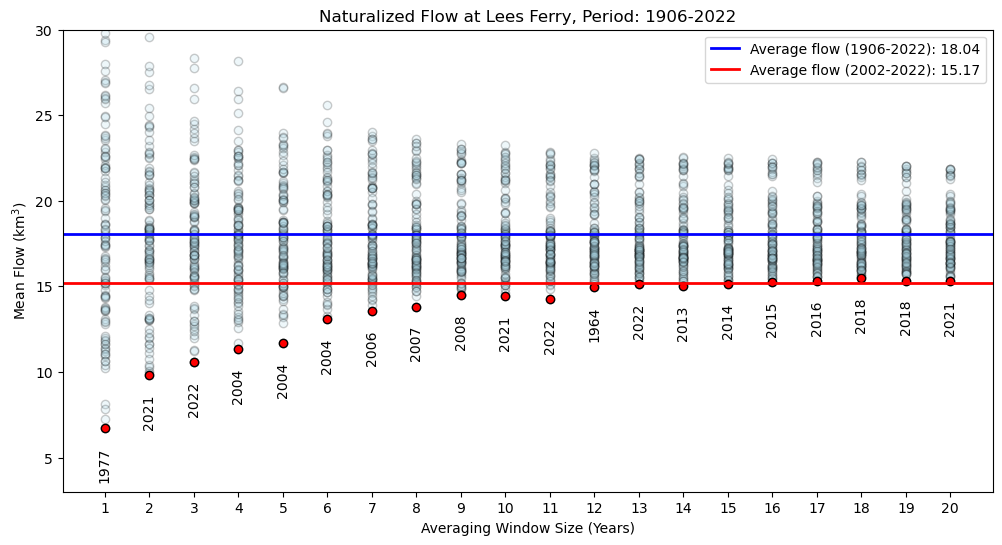

In [81]:
rolling_q_df = pd.DataFrame(rolling_vals)
plt.figure(figsize=(12,6))
for i,col in enumerate(rolling_q_df):
    plt.scatter(np.full(len(rolling_q_df.index),col), rolling_q_df[col], color='lightblue', alpha=0.2, ec='k')
    plt.scatter(col, rolling_q_df.loc[min_start_year[i]+pd.DateOffset(years=1),col], color='red', ec='k')
    plt.text(x=col, 
            y=rolling_q_df.loc[min_start_year[i]+pd.DateOffset(years=1),col]-3, 
            s=(min_start_year[i]+pd.DateOffset(years=1)).year,
            rotation='vertical',
            horizontalalignment='center')
plt.axhline(ucrb_naturalized_streamflow['annual_flow_km3'].mean(), color='blue',lw=2,
            label=f"Average flow (1906-2022): {round(ucrb_naturalized_streamflow['annual_flow_km3'].mean(),2)}")
plt.axhline(ucrb_naturalized_streamflow.loc[2002:2022,'annual_flow_km3'].mean(), color='red',lw=2,
            label=f"Average flow (2002-2022): {round(ucrb_naturalized_streamflow.loc[2002:2022,'annual_flow_km3'].mean(),2)}")
plt.title('Naturalized Flow at Lees Ferry, Period: 1906-2022')
plt.ylabel('Mean Flow (km$^3$)')
plt.xlabel('Averaging Window Size (Years)')
plt.legend()
plt.xticks(rolling_windows);
plt.ylim(3,30)

In [82]:
def cumulativeDeparture(df):
    return (df - ucrb_naturalized_streamflow['annual_flow_km3'].mean()).sum()


In [84]:
rolling_windows_sum = np.arange(1,21,1)
rolling_vals_sum = {}
max_start_year_sum = []
for window in rolling_windows:
    rolling_vals_sum[window] = ucrb_naturalized_streamflow['annual_flow_km3'].rolling(window, center=False).apply(lambda x: cumulativeDeparture(x))
    max_start_year_sum.append(rolling_vals_sum[window].idxmin() - window)

(-60.0, 0.0)

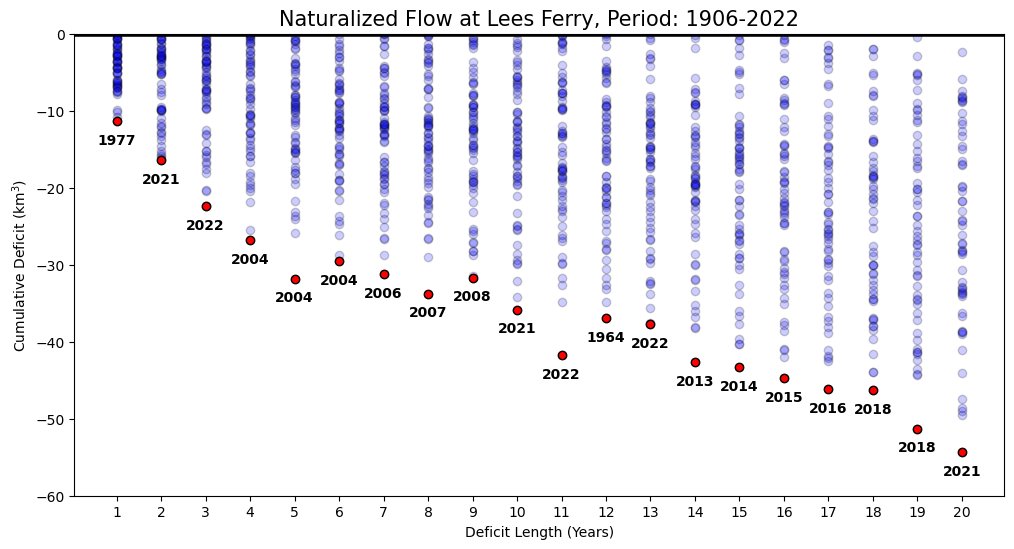

In [85]:
rolling_q_sum_df = pd.DataFrame(rolling_vals_sum)
plt.figure(figsize=(12,6))
plt.axhline(0, color='k',lw=4)
for i,col in enumerate(rolling_q_sum_df):
    plt.scatter(np.full(len(rolling_q_sum_df.index),col), rolling_q_sum_df[col], color='blue', alpha=0.2, ec='k')
    plt.scatter(col, rolling_q_sum_df.loc[max_start_year_sum[i]+col,col], color='red', ec='k')
    plt.text(x=col, 
             y=rolling_q_sum_df.loc[max_start_year_sum[i]+col,col]-3, 
             s=max_start_year_sum[i]+i+1,
             rotation='horizontal',
             horizontalalignment='center',
             # bold the text
             weight='bold')
plt.title('Naturalized Flow at Lees Ferry, Period: 1906-2022', size=15)
plt.ylabel('Cumulative Deficit (km$^3$)')
plt.xlabel('Deficit Length (Years)')
plt.xticks(rolling_windows_sum);
plt.ylim(0-60,0)